In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [3]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

In [4]:
def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>12.6f}', end = ' ')
        print()

# Create dataset

In [5]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}
           }

In [7]:
# root = 'examples/data/periodic/graphene_supercell_variety'
# # HEX22
# names = ['hex'] #, 'hex22']
# ORBS = 'sto-3g'
# frames = read(f'{root}/graphene_variety.xyz', '1:3')

# for frame in frames:
#     frame.pbc = True

# kmesh = [[8,8,1], [4,4,1]]
# # kmesh = [[4,4,1]]
# # kfock = {name: np.load(f"{root}/fock_{name}_{''.join(map(str, kmesh[i]))}.npy") for i, name in enumerate(names)}
# # kover = {name: np.load(f"{root}/over_{name}_{''.join(map(str, kmesh[i]))}.npy") for i, name in enumerate(names)}

# kfock = {name: [np.load(f"{root}/fock_{name2}_{''.join(map(str, kmesh[i]))}.npy") for i, name2 in enumerate(['hex', 'hex22'])] for name in names}
# kover = {name: [np.load(f"{root}/over_{name2}_{''.join(map(str, kmesh[i]))}.npy") for i, name2 in enumerate(['hex', 'hex22'])] for name in names}
# # kfock = {name: [np.load(f"{root}/fock_{name2}_{''.join(map(str, kmesh[i]))}.npy") for i, name2 in enumerate(['hex'])] for name in names}

# for name in kfock:
#     for ifr, (m, o) in enumerate(zip(kfock[name], kover[name])):
#         factor = frames[ifr].get_global_number_of_atoms() * np.sqrt(m.shape[0])
#         m *= factor
#         o *= factor

# dataset = {name: PySCFPeriodicDataset(frames = frames, kgrid = kmesh, matrices_kpoint = kover[name],
#                                       device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS) for i,name in enumerate(names)}

#HEX
# ORBS = 'sto-3g'
# frames = read(f'{root}/graphene_variety.xyz', '1:2')

# for frame in frames:
#     frame.pbc = True

# kmesh = [[8,8,1]]
# # kmesh = [[4,4,1]]
# kfock = {name: np.load(f"{root}/fock_k.npy") for i, name in enumerate(names)}
# kover = {name: np.load(f"{root}/over_k.npy") for i, name in enumerate(names)}

# dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = kfock[name].reshape(1, *kfock[name].shape), 
#                                       overlap_kpoint = kover[name].reshape(1, *kfock[name].shape), target=["real_translation"],
#                                       device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS) for i,name in enumerate(names)}


root = 'examples/data/periodic/c2/'
names = ['hex']
ORBS = 'sto-3g'
START = 2
STOP = 4


frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
fock_range = range(START,STOP)
for frame in frames:
    frame.pbc = True

kmesh = [8,8,1]
for f in frames:
    f.pbc = [True, True, True]

kfock = {name: np.array([np.load(f"examples/data/periodic/c2/fock_{ifock}_{''.join(map(str, kmesh))}.npy") 
                         for ifock in fock_range]
                       ) for name in names 
        }

kover = {name: np.array([np.load(f"examples/data/periodic/c2/over_{ifock}_{''.join(map(str, kmesh))}.npy")
                         for ifock in fock_range]
                       ) for name in names 
        }
for name in ['hex']:
    for ifr, H_k in enumerate(kfock[name]):
        for ik, k in enumerate(H_k):
            kfock[name][ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
    
dataset = {name: PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock[name], overlap_kspace = kover[name], 
                                     device = "cpu", orbs = orbitals[ORBS]) for name in names}

# dataset_pos = {name: PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock[name], overlap_kpoint=kover[name], 
#                                      target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS]) for name in names}

# dataset_neg = {name: PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock[name], overlap_kpoint=kover[name], 
#                                      target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS]) for name in names}

name = 'hex'

In [9]:
superfock = np.load('examples/data/periodic/graphene_supercell_variety/fock_r.npy')
fock = np.load('examples/data/periodic/graphene_supercell_variety/fock_k.npy')

In [13]:
dataset = PySCFPeriodicDataset(frames = frames[:1], kmesh = [4,4,1], fock_kspace = [fock], device = "cpu", orbs = orbitals[ORBS], overlap_kspace = [fock])

In [28]:
dataset._translation_dict

[{(0, 0, 0): [(0, 0, 0)],
  (0, 1, 0): [(0, 1, 0)],
  (0, 2, 0): [(0, 2, 0), (0, -2, 0)],
  (0, -1, 0): [(0, -1, 0)],
  (1, 0, 0): [(1, 0, 0)],
  (1, 1, 0): [(1, 1, 0)],
  (1, 2, 0): [(1, 2, 0)],
  (1, -1, 0): [(1, -1, 0), (1, 3, 0)],
  (2, 0, 0): [(2, 0, 0), (-2, 0, 0)],
  (2, 1, 0): [(2, 1, 0), (-2, -3, 0)],
  (-2, -2, 0): [(-2, -2, 0), (2, 2, 0)],
  (-2, -1, 0): [(-2, -1, 0), (2, 3, 0)],
  (-1, 0, 0): [(-1, 0, 0)],
  (-1, 1, 0): [(-1, 1, 0), (-1, -3, 0)],
  (-1, -2, 0): [(-1, -2, 0)],
  (-1, -1, 0): [(-1, -1, 0)]}]

In [26]:
i = 0
j = 1
dT = (3,0,0)

from mlelec.utils.pbc_utils import get_T_from_pair
from itertools import product

for i in range(2):
    for j in range(2):
        # for dT in [p for p in product(range(4), range(4), range(1))]:
        for dT in dataset.realspace_translations[0]:
            dT = tuple(dT)
            I, J, T = get_T_from_pair(frame, frame.repeat((4,4,1)), i, j, [T[0]%4, T[1]%4, 0], [4,4,1])
            T = tuple(T)
            m1 = np.copy(superfock[0, 5*I:5*(I+1), 5*J:5*(J+1)]*4)
            # m2 = np.copy(dummy_H[tuple(T)][5*i:5*(i+1), 5*j:5*(j+1)])
            m2 = np.copy(dataset.fock_realspace[0][dT][5*i:5*(i+1), 5*j:5*(j+1)])
            m1[np.abs(m1)<1e-1] = 0
            m2[np.abs(m2)<1e-1] = 0
            print(np.linalg.norm(m1-m2))
            # print_matrix(superfock[0, 5*I:5*(I+1), 5*J:5*(J+1)]*4)
            print()
            # print_matrix(dummy_H[tuple(T)][5*i:5*(i+1), 5*j:5*(j+1)])
            # print('\n\n\n')

47.834700073008676

1.3048570220783133

0.0

1.3048570220783131

1.3048570220781577

0.0

0.0

1.3093185101286817

0.0

0.0

0.0

0.0

1.3048570220781575

1.3093185101286817

0.0

0.0

6.784193335334676

0.0

0.0

6.784193335293842

0.0

0.0

0.0

0.5140897804967745

0.0

0.0

0.0

0.0

6.784193335293341

0.5140897804961958

0.0

0.5090119972770906

6.784193335334676

6.784193335293842

0.0

0.0

6.784193335293342

0.5090119972770907

0.0

0.5140897804961958

0.0

0.0

0.0

0.0

0.0

0.5140897804967747

0.0

0.0

47.834700072752064

1.3048570220539015

0.0

1.3048570220539013

1.3048570220537057

0.0

0.0

1.3093185101102447

0.0

0.0

0.0

0.0

1.304857022053706

1.3093185101102447

0.0

0.0



# Compute targets

In [9]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu"):
    blocks = matrix_to_blocks(dataset, dataset._fock_realspace_negative_translations, device = 'cpu')
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)
    

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [10]:
target_blocks = {name: get_targets(dataset[name])[0] for name in ['hex']}
target_coupled_blocks = {name: get_targets(dataset[name])[1] for name in ['hex']}

# MUST PASS 
check_target(target_coupled_blocks[name])

# target_blocks_pos = {name: get_targets(dataset_pos[name], H_T_minus_pos)[0] for name in ['hex']}
# target_coupled_blocks_pos = {name: get_targets(dataset_pos[name], H_T_minus_pos)[1] for name in ['hex']}

# # MUST PASS 
# check_target(target_coupled_blocks_pos[name])

# target_blocks_neg = {name: get_targets(dataset_neg[name], H_T_minus_neg)[0] for name in ['hex']}
# target_coupled_blocks_neg = {name: get_targets(dataset_neg[name], H_T_minus_neg)[1] for name in ['hex']}

## MUST PASS 
# check_target(target_coupled_blocks_neg[name])

TARGET PASSED


# Compute features

In [11]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

def get_pair_features(frames, hypers_atoms, hypers_pair, order_nu, all_pairs, both_centers, max_shift, mic, kmesh, device, lcut,return_rho0ij, counter, T_dict):
    return pair_features(frames, hypers_atoms, hypers_pair, order_nu=order_nu, all_pairs=all_pairs, both_centers = both_centers, max_shift = max_shift,
            mic=mic, kmesh=kmesh, device=device, lcut=lcut,return_rho0ij=return_rho0ij, counter = counter, T_dict = T_dict)

def rascaline_gij(dataset):
    from mlelec.features.acdc_utils import fix_gij, acdc_standardize_keys
    hypers_pair = {'cutoff': 12,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    from rascaline import SphericalExpansionByPair 
    calculator = SphericalExpansionByPair(**hypers_pair)
    gij= calculator.compute(dataset.structures)
    gij = fix_gij(gij)
    gij = acdc_standardize_keys(gij)
    return gij

def compute_features(dataset, return_rho0ij = False, both_centers=True):
# +
    hypers_pair = {'cutoff': 4,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }

    hypers_atom = {'cutoff': 4,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.3,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    device = "cpu"
    # -

    LCUT = 3 #2*np.max([np.max( np.asarray(orbitals[ORBS][k])[:,1]) for k in orbitals[ORBS]])
    print("LCUT", LCUT)

    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2

    print(return_rho0ij)

    rhoij = get_pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers = both_centers,
                                max_shift = dataset.kmesh, mic = True,
                                kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, T_dict = dataset._translation_dict)

    print('rhoij computed')
    if return_rho0ij:
        # return rhoij
        NU = 1 
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut=LCUT, device = device,
                                    feature_names = rhoij.property_names)
    return rhonui, rhoij

def compute_hfeat(rhonui, rhoij):
    hfeat = twocenter_features_periodic_NH(single_center=rhonui, pair= rhoij)
    return hfeat

In [12]:
# from mlelec.features.acdc import twocenter_hermitian_features # Molecular 
return_gij = False
both_centers = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, both_centers = both_centers)
hfeat = compute_hfeat(rhonui, rhoij)

LCUT 3
False
hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:145: UserWarning: Using cutoff 11.0 for all pairs feature
  warnings.warn(
/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [[8, 8, 1], [8, 8, 1]] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")
/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:269: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


rhoij computed


In [38]:
# hfeat = load('features_struct_2-3-4.npz').to(arrays = 'torch')
# hfeat = load('features_struct_2-3-4-onlyzero-nobothcenters.npz').to(arrays = 'torch')


In [39]:
pos_target_samples = target_coupled_blocks_pos['hex'][20].samples
blocks = []
for k, b in hfeat.items():
    if k['block_type']==0:
        blocks.append(b.copy())
    else: 
        flbls = Labels(hfeat.sample_names[:6], np.array(b.samples.values[:,:6]))
        idx = np.where(flbls.intersection_and_mapping(pos_target_samples)[1] !=-1)[0]
        samples = Labels(hfeat.sample_names, np.array(b.samples.values[idx].tolist()))
        blocks.append( TensorBlock(components = b.components, 
                                   properties = b.properties,
                                   samples = samples, 
                                   values = b.values[idx]))

hfeat_pos = TensorMap(hfeat.keys, blocks)                                

NameError: name 'target_coupled_blocks_pos' is not defined

In [21]:
neg_target_samples = target_coupled_blocks_neg['hex'][20].samples
blocks = []
for k, b in hfeat.items():
    if k['block_type']==0:
        blocks.append(b.copy())
    else: 
        flbls = Labels(hfeat.sample_names[:6], np.array(b.samples.values[:,:6]))
        idx = np.where(flbls.intersection_and_mapping(neg_target_samples)[1] !=-1)[0]
        samples = Labels(hfeat.sample_names, np.array(b.samples.values[idx].tolist()))
        blocks.append( TensorBlock(components = b.components, 
                                   properties = b.properties,
                                   samples = samples, 
                                   values = b.values[idx]))

hfeat_neg = TensorMap(hfeat.keys, blocks)

In [22]:
reduced_features = {}
reduced_targets = {}

for n, log_op in zip(['ii', 'ij', 'ji', 'ijji'], [np.equal, np.less, np.greater, np.not_equal]):
    reduced_features[n] = {}
    reduced_targets[n] = {}
    for T_sign, f, t in zip(['+', '-'], [hfeat_pos, hfeat_neg], [target_coupled_blocks_pos['hex'], target_coupled_blocks_neg['hex']]):
        
        # Reduce features
        blocks = []
        klist = []
        for k, b in f.items():
            sample_idx = np.where(log_op(b.samples.values[:, 1], b.samples.values[:, 2]))
            samples = Labels(b.samples.names, b.samples.values[sample_idx])
            if len(sample_idx[0])!=0:
                klist.append(k.values)
                blocks.append(
                    TensorBlock(
                        samples = samples,
                        values = b.values[sample_idx],
                        properties = b.properties,
                        components = b.components)
                )
        reduced_features[n][T_sign] = TensorMap(Labels(f.keys.names, np.array(klist)), blocks)  

        # Reduce targets
        blocks = []
        klist = []
        for k, b in t.items():
            sample_idx = np.where(log_op(b.samples.values[:, 1], b.samples.values[:, 2]))
            samples = Labels(b.samples.names, b.samples.values[sample_idx])
            if len(sample_idx[0])!=0:
                klist.append(k.values)
                blocks.append(
                    TensorBlock(
                        samples = samples,
                        values = b.values[sample_idx],
                        properties = b.properties,
                        components = b.components)
                )
        reduced_targets[n][T_sign] = TensorMap(Labels(t.keys.names, np.array(klist)), blocks)

# Train linear-algebra model

In [13]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [14]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [23]:
model_ridge = LinearModelPeriodic(
                                  twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks['hex'],
                                  frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks['hex'],
                                                                         set_bias = True)
print(loss_ridge_bias)

tensor(5.4611e-07)


In [24]:
from mlelec.utils.plot_utils import plot_block_errors

(1e-12, 10000.0)

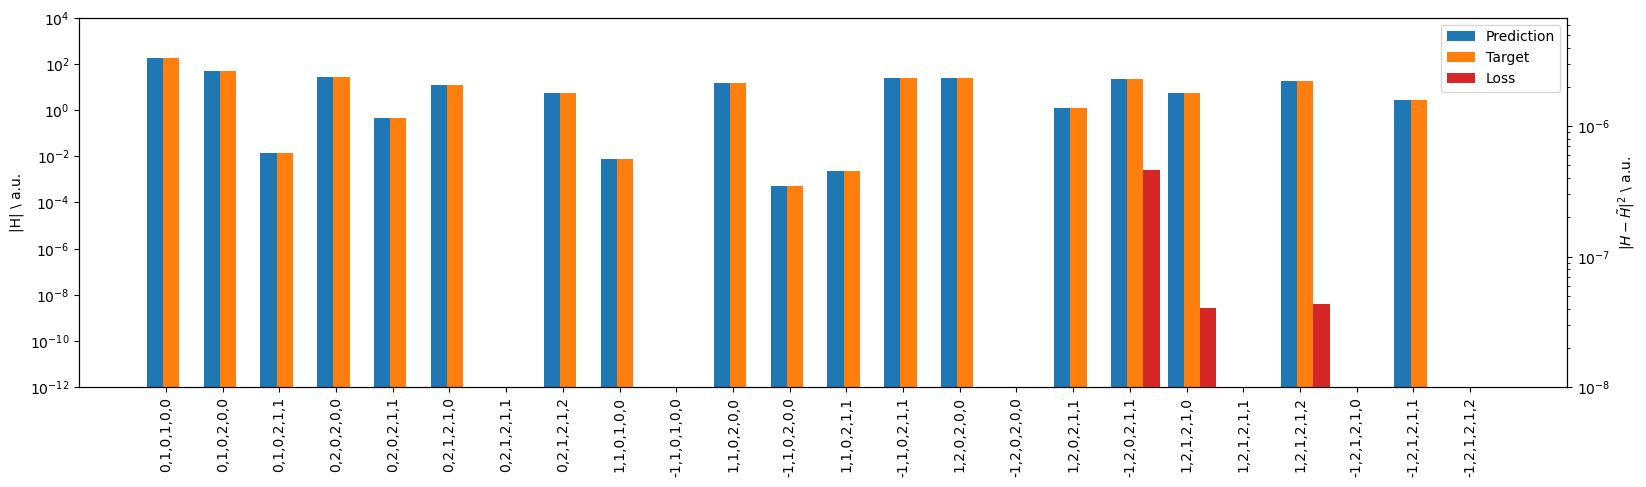

In [25]:
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks['hex'], pred_ridge_bias, plot_loss=True)
ax_loss.set_ylim(1e-8,)
ax.set_ylim(1e-12,1e4)

In [ ]:
kernel = []
for k, b in hfeat.items():
    x = b.values.reshape(-1, b.values.shape[-1])
    kernel.append(x@x.T)
    

In [ ]:
ridges_bias[ik]

In [52]:
loaded_hfeat = load('features_struct_2-3-4.npz').to(arrays = 'torch')

In [54]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
predictions = []
for ik, k in enumerate(target_coupled_blocks['hex'].keys):
    fkey = map_targetkeys_to_featkeys(loaded_hfeat, k, return_key=True)
    ifeat = loaded_hfeat.keys.values.tolist().index(list(fkey.values[0]))
    # predictions.append(ridges_bias[ik].predict(kernel[ifeat]))
    val = loaded_hfeat.block(fkey).values
    pred = ridges_bias[ik].predict(val.reshape(-1, val.shape[-1]))
    predictions.append(pred)
    # err = np.linalg.norm(pred - pred_ridge_bias.block(k).values.reshape(pred.shape).numpy())
    # if err>1e-5:
    # print(err)

In [57]:
pred.reshape(pred_ridge_bias.block(k).values.shape)

ValueError: cannot reshape array of size 3810 into shape (380,5,1)

In [42]:
hfeat.keys.values.tolist().index([3,1,0,6,6,0])

0

In [43]:
print(hfeat.keys.values.tolist())
hfeat.keys.values.tolist().index(list(fkey.values[0]))

[[3, 1, 0, 6, 6, 0], [3, 1, 1, 6, 6, 0], [3, 1, 2, 6, 6, 0], [3, 1, 3, 6, 6, 0], [3, -1, 1, 6, 6, 0], [3, -1, 2, 6, 6, 0], [3, -1, 3, 6, 6, 0], [3, -1, 0, 6, 6, 0], [3, 1, 0, 6, 6, 1], [3, 1, 0, 6, 6, -1], [3, 1, 1, 6, 6, 1], [3, 1, 1, 6, 6, -1], [3, 1, 2, 6, 6, 1], [3, 1, 2, 6, 6, -1], [3, 1, 3, 6, 6, 1], [3, 1, 3, 6, 6, -1], [3, -1, 1, 6, 6, 1], [3, -1, 1, 6, 6, -1], [3, -1, 2, 6, 6, 1], [3, -1, 2, 6, 6, -1], [3, -1, 3, 6, 6, 1], [3, -1, 3, 6, 6, -1], [3, -1, 0, 6, 6, 1], [3, -1, 0, 6, 6, -1]]


0

In [32]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
map_targetkeys_to_featkeys?

Signature:
map_targetkeys_to_featkeys(
    features,
    key,
    cell_shift=None,
    return_key=False,
)
Docstring: <no docstring>
File:      ~/Software/my_mlelec/src/mlelec/utils/twocenter_utils.py
Type:      function

In [ ]:
from sklearn.model_selection import GridSearchCV
def test_regress_kernel(kernel, y, itrain, itest, alphas=[1e-12], tf=0.5, cv=3):
    ntrain = int(len(kernel)*tf)
    krcv = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(krcv, dict(alpha = alphas), cv=cv)
    ktrain = kernel[itrain][:,itrain]
    #ktest = kernel[itrain][:, itest]
    gscv.fit(ktrain, y[itrain])
    cv_stats = gscv.cv_results_
    alpha = gscv.best_params_["alpha"]
    clf = KernelRidge(kernel="precomputed", alpha = alpha)
    clf.fit(ktrain, y[itrain])
    print("Best regularizer ", clf.alpha, " ntrain", ntrain, file=sys.stderr)
    predictions = clf.predict(kernel[:][:,itrain])
    print("Train error: %10.5f;  Test error: %10.5f" %(
    get_error(predictions[itrain], y[itrain]) / get_spread(y), get_error(predictions[itest], y[itest]) / get_spread(y)), file=sys.stderr)
    return predictions[itrain],predictions[itest]

In [43]:
# Reconstruct realspace matrices 
from mlelec.utils.pbc_utils import blocks_to_matrix
rHplus, rHminus = blocks_to_matrix(pred_ridge_bias, dataset['hex'])
print(np.sqrt(np.sum([torch.norm(H1[T]-H2[T]).item()**2 for H1, H2 in zip(rHplus, dataset['hex'].fock_realspace) for T in H1])))

0.0009982230154400582


In [39]:
for ifr in range(dataset['hex'].__len__()):
    for T in rHplus[ifr]:
        norm = torch.norm(rHplus[ifr][T] - dataset['hex'].fock_realspace[ifr][T])
        print(ifr, T, norm)

0 (0, 0, 0) tensor(4.7788e-07)
0 (0, 1, 0) tensor(9.3264e-07)
0 (0, 2, 0) tensor(1.1785e-05)
0 (0, 3, 0) tensor(3.5073e-05)
0 (0, 4, 0) tensor(7.5932e-05)
0 (0, -3, 0) tensor(3.5073e-05)
0 (0, -2, 0) tensor(1.1785e-05)
0 (0, -1, 0) tensor(9.3264e-07)
0 (1, 0, 0) tensor(8.6401e-07)
0 (1, 1, 0) tensor(8.8362e-07)
0 (1, 2, 0) tensor(1.5720e-05)
0 (1, 3, 0) tensor(0.0001)
0 (1, 4, 0) tensor(5.4235e-05)
0 (1, -3, 0) tensor(0.0001)
0 (1, -2, 0) tensor(0.0001)
0 (1, -1, 0) tensor(5.1919e-06)
0 (2, 0, 0) tensor(1.2808e-05)
0 (2, 1, 0) tensor(1.4075e-05)
0 (2, 2, 0) tensor(9.3068e-06)
0 (2, 3, 0) tensor(0.0001)
0 (2, 4, 0) tensor(8.3800e-05)
0 (2, 5, 0) tensor(9.3269e-05)
0 (2, -2, 0) tensor(0.0002)
0 (2, -1, 0) tensor(0.0001)
0 (3, 0, 0) tensor(5.9627e-05)
0 (3, 1, 0) tensor(8.6989e-05)
0 (3, 2, 0) tensor(6.7388e-05)
0 (3, 3, 0) tensor(7.8047e-05)
0 (3, 4, 0) tensor(0.0001)
0 (3, 5, 0) tensor(8.1254e-05)
0 (3, -2, 0) tensor(5.5168e-05)
0 (3, -1, 0) tensor(0.0002)
0 (4, 0, 0) tensor(6.2354e-05)

In [40]:
# Reconstruct kspace matrices 
recon_matrices_kspace = dataset['hex'].compute_matrices_kspace(rHplus)

In [47]:
np.sqrt(np.sum([torch.norm(H1-H2).item()**2 for H1, H2 in zip(recon_matrices_kspace, dataset['hex'].fock_kspace)]))

0.0009982230154414182

In [28]:
reduced_pred = {}
reduced_ridges = {}

from copy import deepcopy

for n in reduced_features:
    reduced_pred[n] = {}
    reduced_ridges[n] = {}
    
    for T_sign in reduced_features[n]:
        model_ridge = LinearModelPeriodic(
                                          twocfeat = reduced_features[n][T_sign], 
                                          target_blocks = reduced_targets[n][T_sign],
                                          frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                          cell_shifts = None, device = device)
        
        model_ridge = model_ridge.double()
        loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                                 reduced_targets[n][T_sign],
                                                                                 set_bias = False)
        reduced_pred[n][T_sign] = pred_ridge_bias.copy()
        reduced_ridges[n][T_sign] = deepcopy(ridges_bias)
        
        print(n, T_sign, loss_ridge_bias)

ii + tensor(3.9521e-10)
ii - tensor(3.9521e-10)
ij + tensor(2.8686e-12)
ij - tensor(1.8249e-09)
ji + tensor(1.8249e-09)
ji - tensor(2.8686e-12)
ijji + tensor(2.6559e-09)
ijji - tensor(2.6559e-09)


(array([ 1.,  1.,  0.,  3.,  4., 10.,  3.,  2.,  1.,  2.]),
 array([-17.47234726, -14.24275399, -11.01316073,  -7.78356746,
         -4.55397419,  -1.32438093,   1.90521234,   5.13480561,
          8.36439888,  11.59399214,  14.82358541]),
 <BarContainer object of 10 artists>)

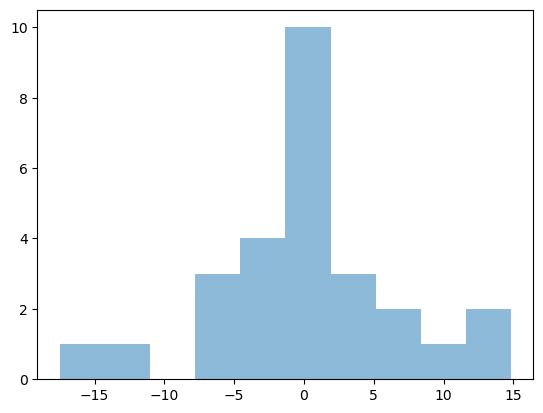

In [30]:
plt.hist(reduced_ridges['ij']['+'][8].dual_coef_.flatten(), alpha = 0.5) #, bins = 20);
# plt.hist(reduced_ridges['ji']['+'][8].dual_coef_.flatten(), alpha = 0.5) #, bins = 20);
# plt.hist(reduced_ridges['ijji']['+'][8].dual_coef_.flatten(), alpha = 0.5) #, bins = 20);

ValueError: x and y must have same first dimension, but have shapes (8,) and (4,)

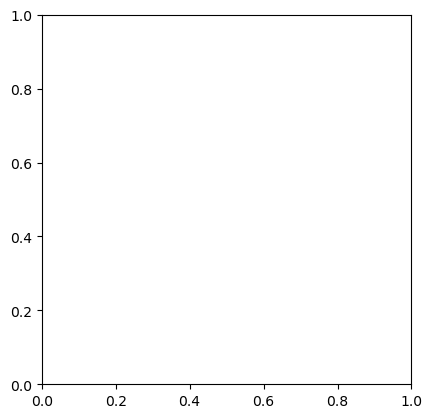

In [31]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(reduced_ridges['ijji']['+'][8].dual_coef_.flatten(), reduced_ridges['ij']['+'][8].dual_coef_.flatten(), '.')
ax.plot(reduced_ridges['ijji']['+'][8].dual_coef_.flatten(), reduced_ridges['ji']['+'][8].dual_coef_.flatten(), '.')

xmin = np.min([reduced_ridges['ijji']['+'][8].dual_coef_.flatten(), reduced_ridges['ij']['+'][8].dual_coef_.flatten()])
xmax = np.max([reduced_ridges['ijji']['+'][8].dual_coef_.flatten(), reduced_ridges['ij']['+'][8].dual_coef_.flatten()])
ax.plot([xmin, xmax], [xmin, xmax])
ax.axhline(0, ls = '--', c = 'k')
ax.axvline(0, ls = '--', c = 'k')


In [113]:
model_ridge_ij = LinearModelPeriodic(
                                          twocfeat = reduced_features['ij']['+'], 
                                          target_blocks = reduced_targets['ij']['+'],
                                          frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                          cell_shifts = None, device = device)
        
model_ridge_ij = model_ridge.double()


In [114]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
device= "cpu"
pred_blocks_ij = []
dummy_property = reduced_targets['ij']['+'][0].properties
targetkeynames = reduced_targets['ij']['+'].keys.names
for imdl, (key, tkey) in enumerate(zip(model_ridge_ij.model, reduced_targets['ij']['+'].keys)):
    target = reduced_targets['ij']['+'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(reduced_features['ij']['+'], tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = reduced_ridges['ijji']['+'][imdl].predict(x)
    pred_blocks_ij.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )
pred_ij = TensorMap(reduced_targets['ij']['+'].keys, pred_blocks_ij)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| \\ a.u.'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$ \\ a.u.'>)

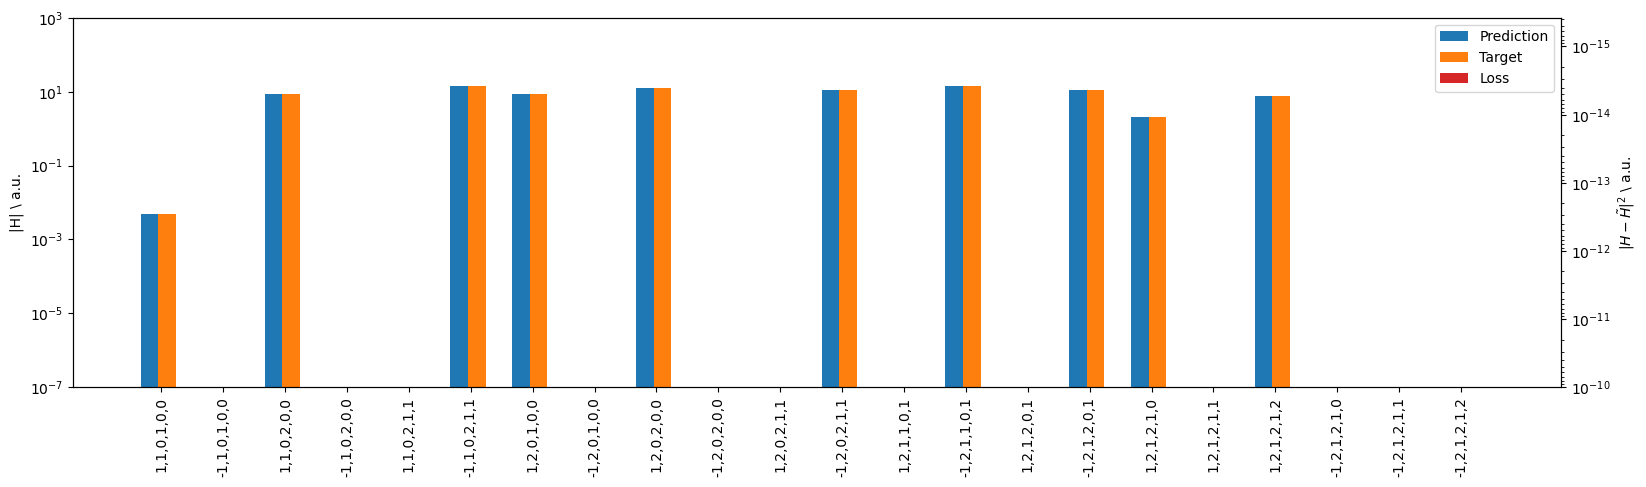

In [115]:
plot_block_errors(reduced_targets['ij']['+'], pred_ij, plot_loss=True)

In [116]:
model_ridge_ijji = LinearModelPeriodic(
                                          twocfeat = reduced_features['ijji']['+'], 
                                          target_blocks = reduced_targets['ijji']['+'],
                                          frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                          cell_shifts = None, device = device)
        
model_ridge_ijji = model_ridge.double()

In [117]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
device= "cpu"
pred_blocks_ijji = []
dummy_property = reduced_targets['ijji']['+'][0].properties
targetkeynames = reduced_targets['ijji']['+'].keys.names
loss = 0
for imdl, (key, tkey) in enumerate(zip(model_ridge_ij.model, reduced_targets['ijji']['+'].keys)):
    target = reduced_targets['ijji']['+'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(reduced_features['ijji']['+'], tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = reduced_ridges['ij']['+'][imdl].predict(x)
    pred_blocks_ijji.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )
    loss += np.linalg.norm(pred.flatten() - reduced_targets['ijji']['+'].block(tkey).values.numpy().flatten())**2
pred_ijji = TensorMap(reduced_targets['ijji']['+'].keys, pred_blocks_ijji)
print(loss)

2.992540264501332e+17


In [118]:
reduced_ridges['ij']['+'][8].alpha_, reduced_ridges['ijji']['+'][8].alpha_

(0.005872786613189537, 1e-50)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| \\ a.u.'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$ \\ a.u.'>)

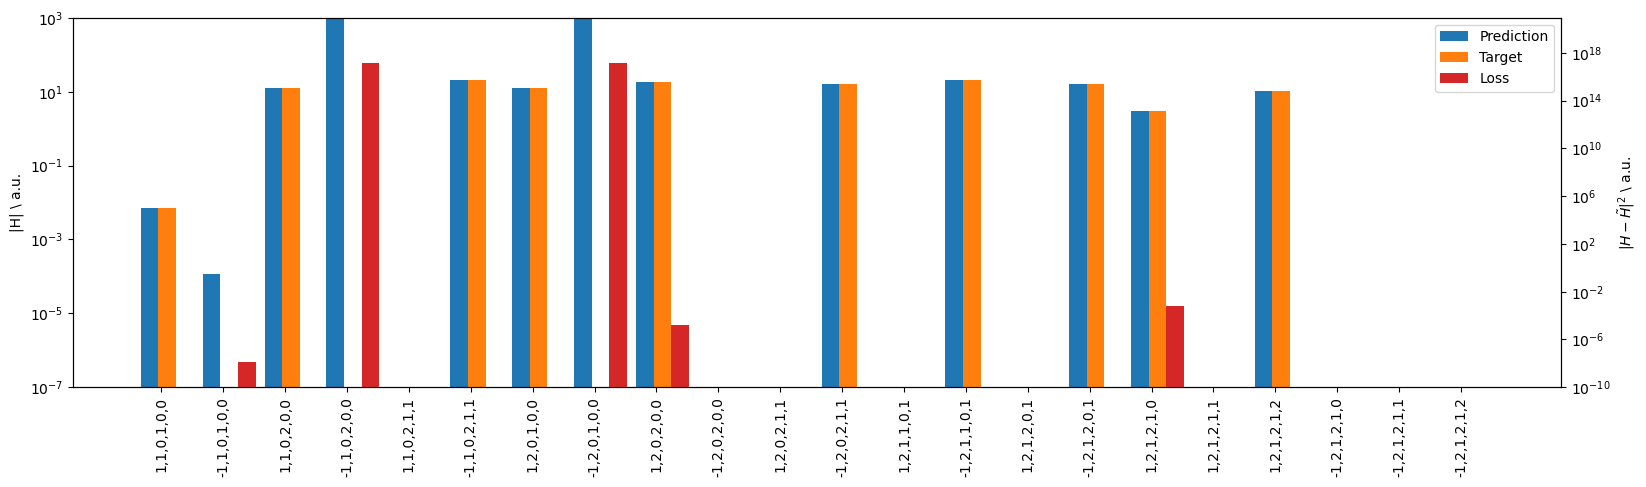

In [119]:
plot_block_errors(reduced_targets['ijji']['+'], pred_ijji, plot_loss=True)

In [ ]:
red

In [28]:
blocks = []
for k, b in reduced_targets['ij']['+'].items():
    blocks.append(
        TensorBlock(values = reduced_targets['ji']['-'].block(k).values,
                    components = b.components,
                    properties = b.properties,
                    samples = b.samples)
    )
bizarre_targets = TensorMap(reduced_targets['ij']['+'].keys, blocks)

In [62]:
model_ridge = LinearModelPeriodic(
                                  twocfeat= reduced_features['ij']['+'], 
                                  target_blocks = bizarre_targets, 
                                  frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                  cell_shifts=dataset['hex'].desired_shifts[:], device = device)
model_ridge = model_ridge.double()

In [63]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         bizarre_targets, 
                                                                         # reduced_targets_ji,
                                                                         set_bias = True)
print(loss_ridge_bias)

tensor(0.2299)


In [72]:
bizarre_targets[21].samples

Labels(
    structure  center  neighbor  cell_shift_a  cell_shift_b  cell_shift_c
        0        0        1           0             0             0
        1        0        1           0             0             0
        2        0        1           0             0             0
)

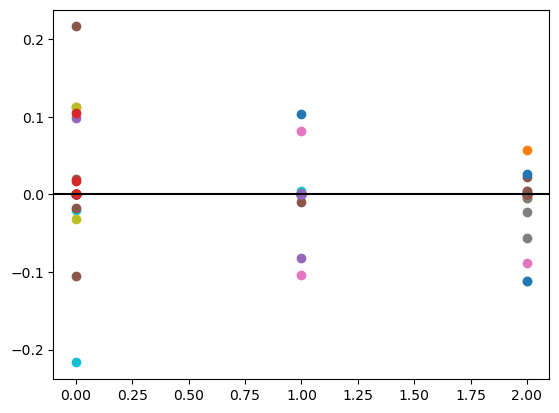

In [85]:
import matplotlib.pyplot as plt
for k, b in bizarre_targets.items():
    delta = pred_ridge_bias.block(k).values - b.values
    for i, s in enumerate(delta):
        y = s.flatten().numpy()
        plt.plot(np.ones(y.size)*i, y, 'o')
plt.axhline(0, c = 'k')

In [79]:
delta.shape

torch.Size([3, 5, 1])

ii + tensor(5.6705e-16)
ii - tensor(5.6705e-16)
ij + tensor(0.2299)
ij - tensor(0.2299)
ji + tensor(0.2299)
ji - tensor(0.2299)
ijji + tensor(6.4590e-17)
ijji - tensor(6.4590e-17)

In [37]:
from metatensor.operations import join
amazing_features = join([reduced_features['ii']['+'], reduced_features['ii']['-'], reduced_features['ij']['-'], reduced_features['ji']['+']], axis = 'samples', remove_tensor_name = True)
amazing_targets = join([reduced_targets['ij']['-'], reduced_targets['ji']['+']], axis = 'samples', remove_tensor_name = True)

In [41]:
model_ridge = LinearModelPeriodic(
                                  twocfeat = amazing_features, 
                                  target_blocks = amazing_targets,
                                  frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                  cell_shifts = None, device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         amazing_targets,
                                                                         set_bias = True)
amazing_pred = pred_ridge_bias.copy()
print('amazing!:', loss_ridge_bias)

amazing!: tensor(3.3164e-14)


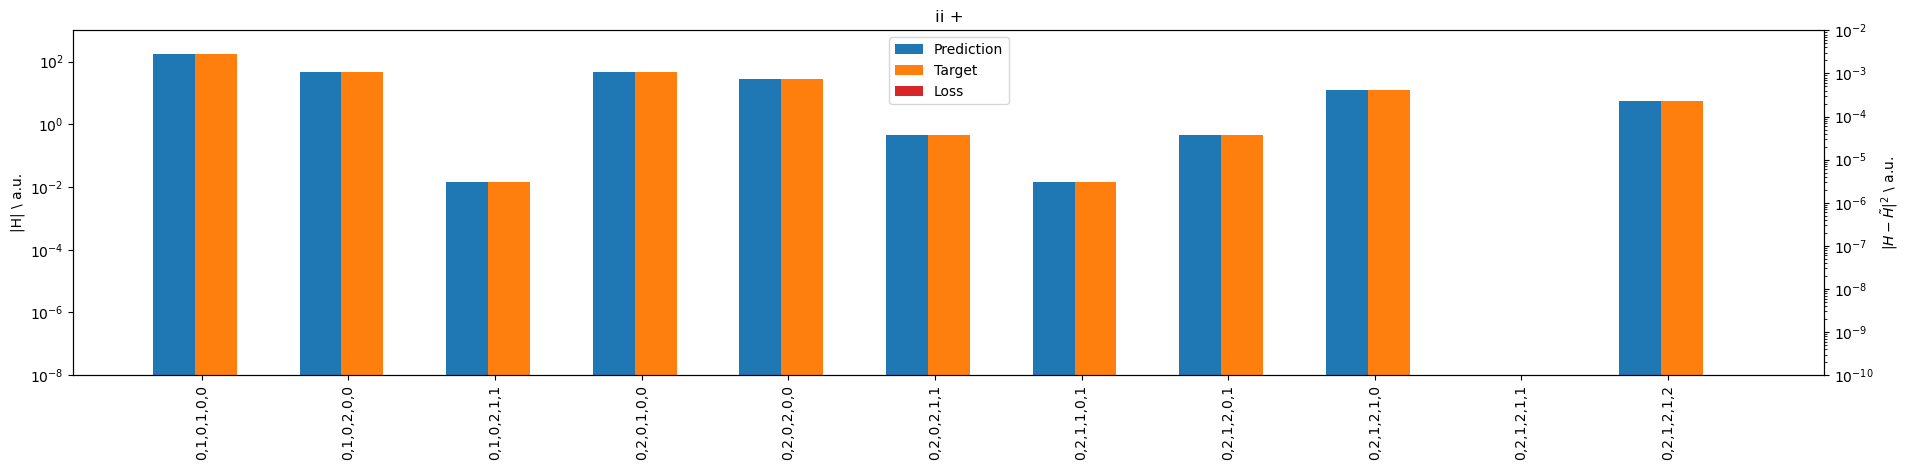

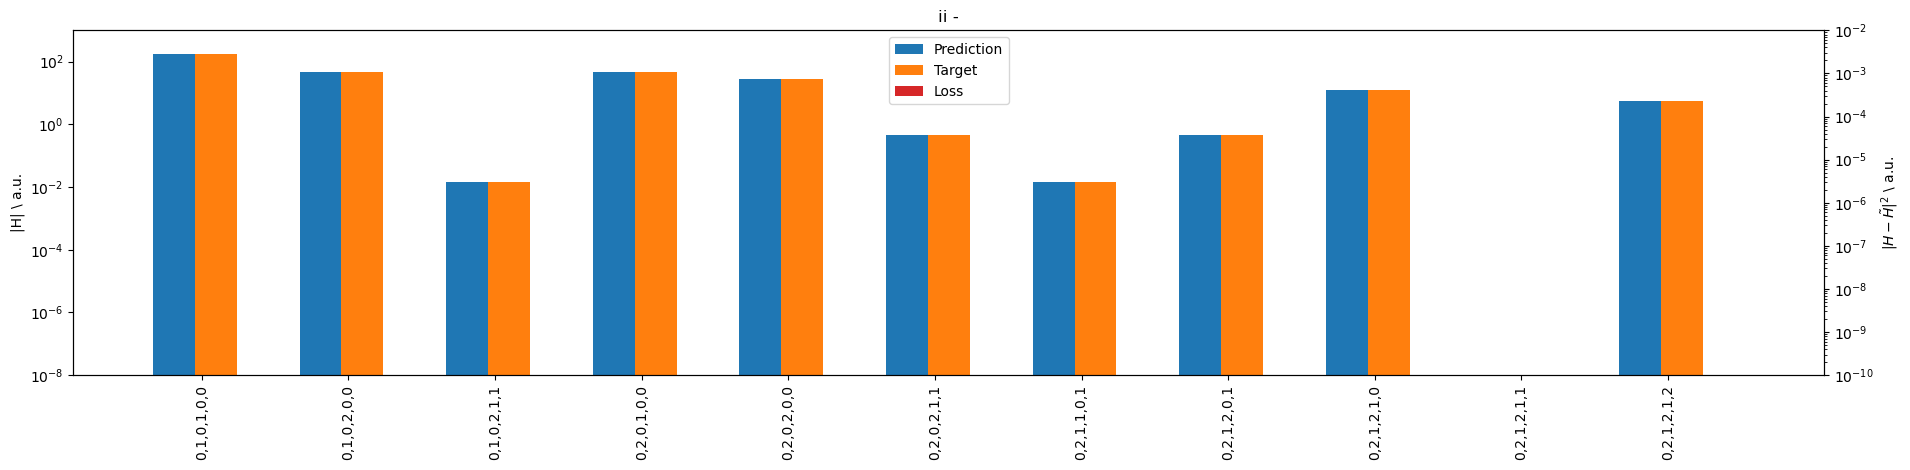

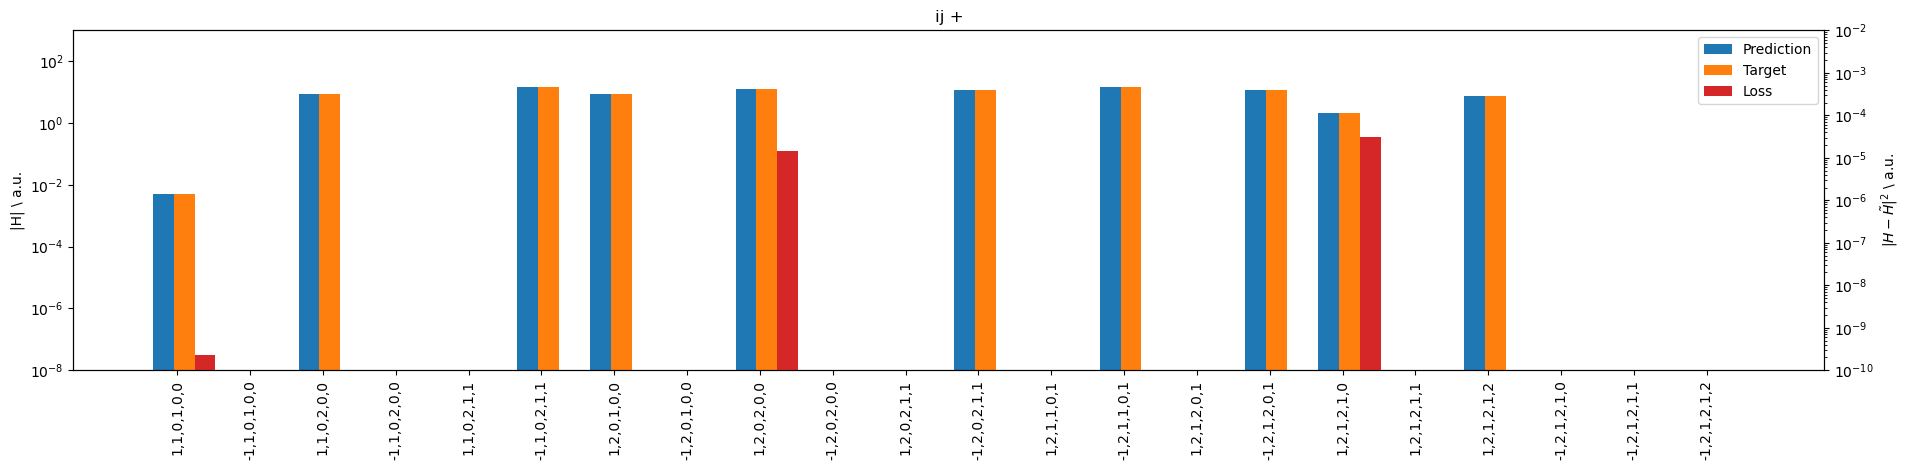

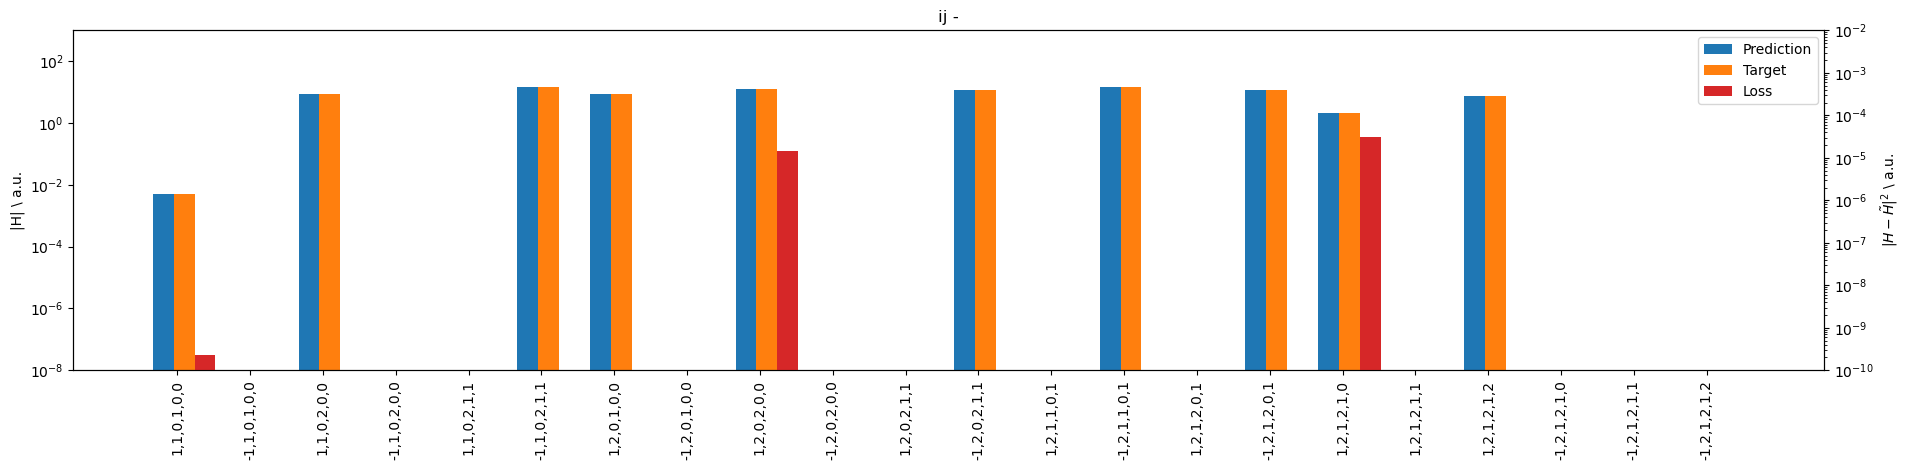

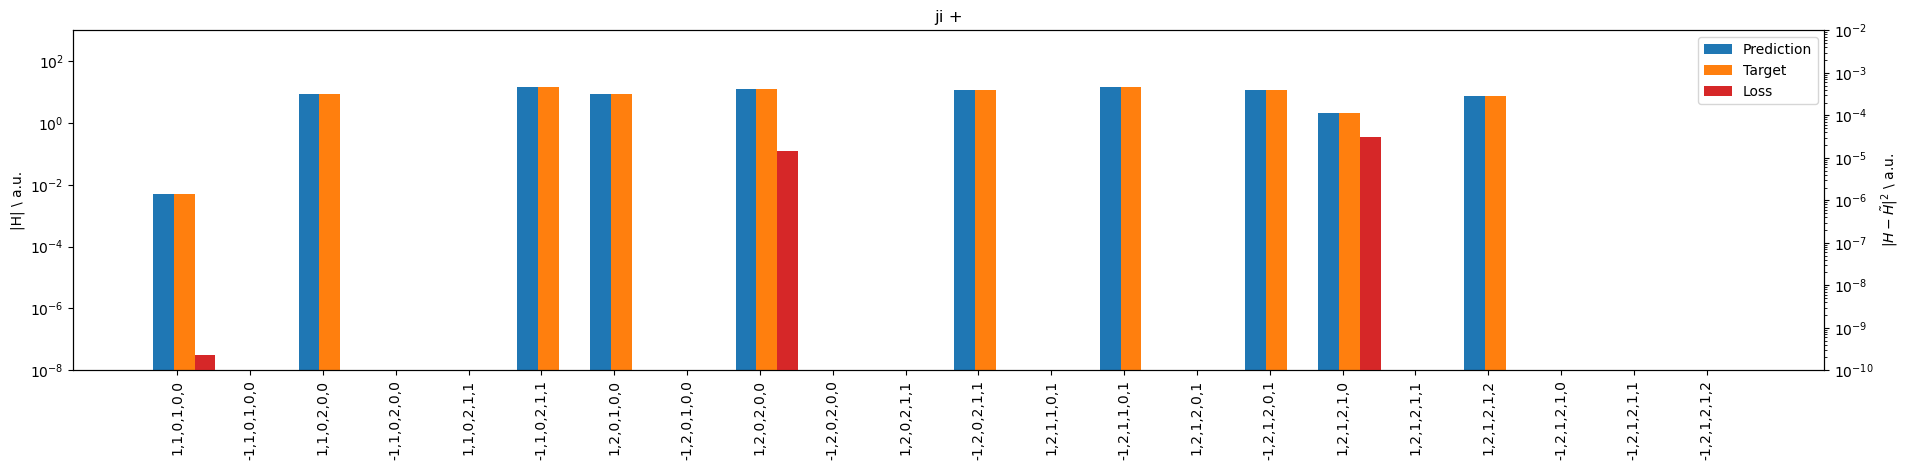

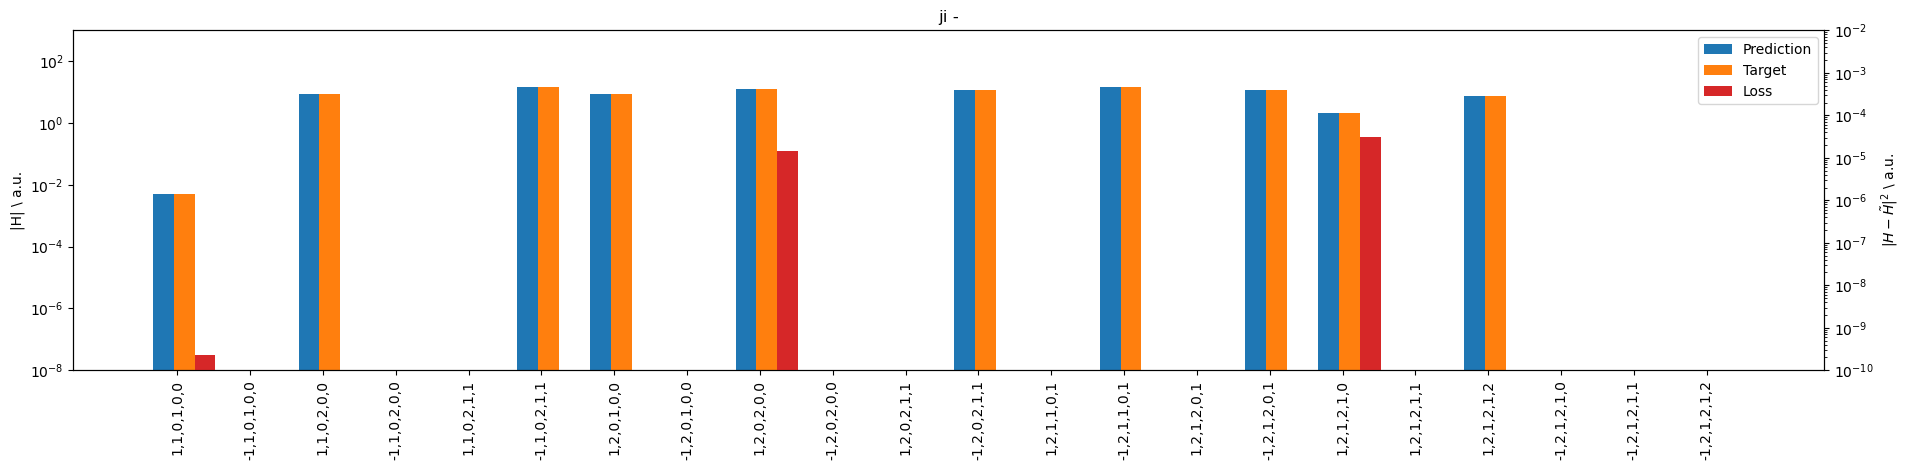

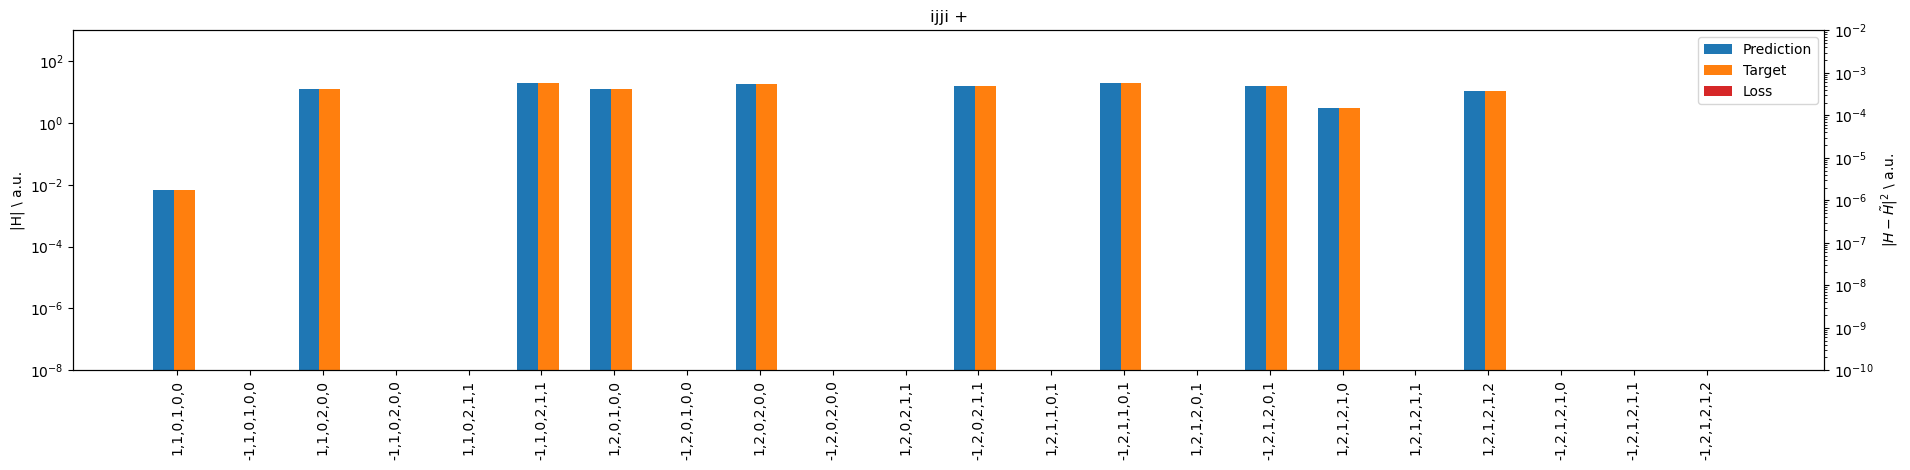

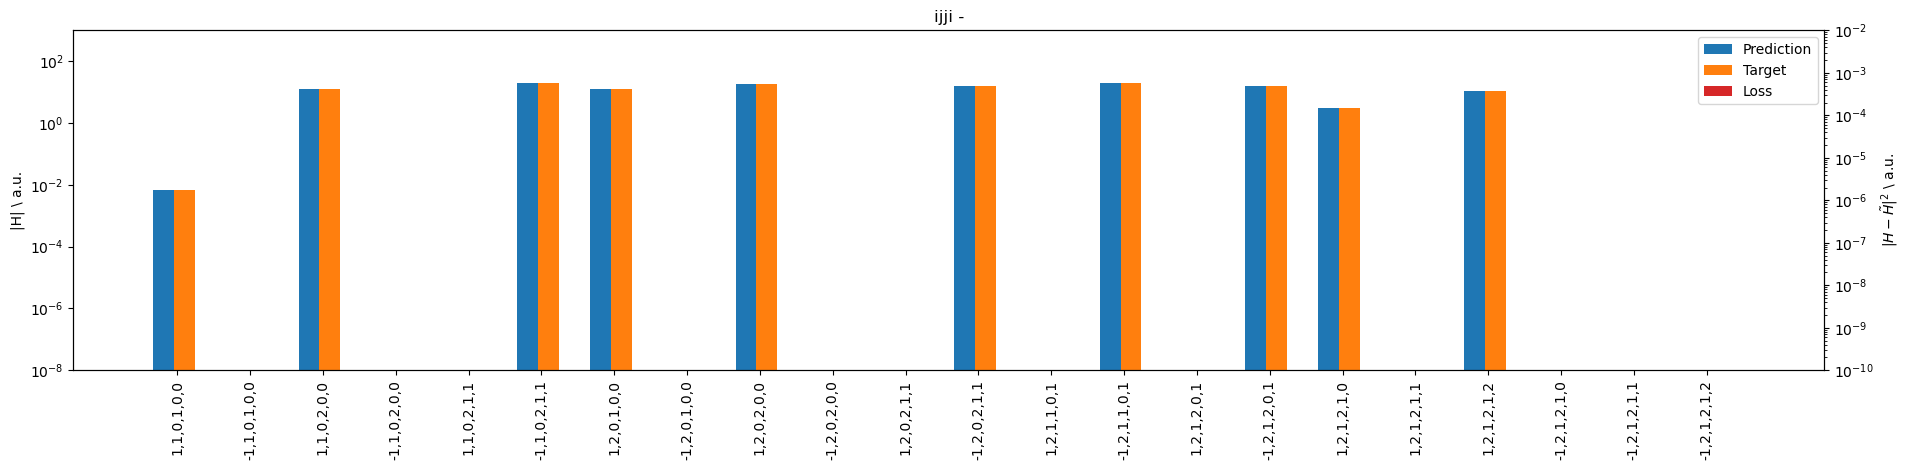

In [29]:
from mlelec.utils.plot_utils import plot_block_errors

for n in reduced_pred:
    for T_sign in reduced_pred[n]:
        fig, ax, ax_loss = plot_block_errors(reduced_targets[n][T_sign],
                                             reduced_pred[n][T_sign], 
                                             plot_loss=True)
        ax_loss.set_ylim(1e-10,1e-2)
        ax.set_ylim(1e-8,1e3)
        ax.set_title(n + ' ' + T_sign)
        
        fig.tight_layout()

# I am here

In [131]:
def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>12.2e}', end = ' ')
        print()

In [141]:
ifr = 1
i = 0
j = 1

idxi = slice(i*5,(i+1)*5)
idxj = slice(j*5,(j+1)*5)

T = -1,-2,0
# T = 1,0,0
print_matrix(H_T_plus[ifr][T][idxi, idxj][-3:,-3:] + H_T_minus[ifr][T][idxj, idxi][-3:,-3:])
print()
print(torch.trace(H_T_plus[ifr][T][idxi, idxj][-3:,-3:] + H_T_minus[ifr][T][idxj, idxi][-3:,-3:]))
# print_matrix(H_T_minus[ifr][T][idxj, idxi])


    1.88e+00    -1.33e-14     6.20e-07 
   -1.33e-14    -4.90e-02     2.51e-13 
    6.20e-07     2.51e-13    -5.35e-01 

tensor(1.2930)


In [148]:
import matplotlib.pyplot as plt

In [152]:
reduced_targets['ijji'][16].samples.values

LabelsValues([[ 0,  0,  1, -4, -4,  0],
              [ 0,  0,  1, -4, -3,  0],
              [ 0,  0,  1, -4, -2,  0],
              ...,
              [ 2,  1,  0,  4,  1,  0],
              [ 2,  1,  0,  4,  2,  0],
              [ 2,  1,  0,  4,  3,  0]], dtype=int32)

In [157]:
np.argwhere(stru==s).flatten()[0]

0

In [196]:
reduced_pred[lbl]

TensorMap with 33 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          0           6       1    0       6       1    0   0
          0           6       1    0       6       2    0   0
                               ...
          -1          6       2    1       6       2    1   1
          -1          6       2    1       6       2    1   2

(-0.0032970228258110664, 0.004056223237842788)

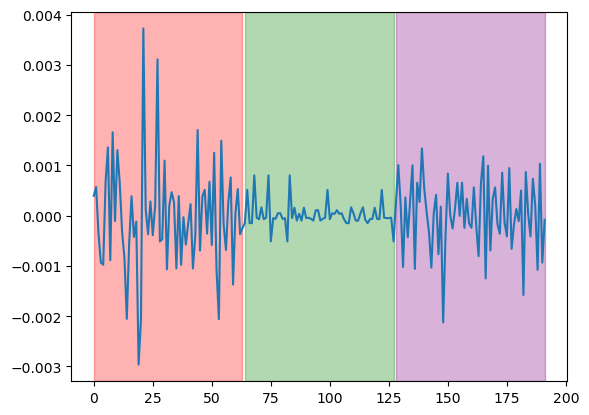

In [200]:
# plt.plot(reduced_pred['ij'][16].values.flatten() - reduced_targets['ij'][16].values.flatten())
fig, ax = plt.subplots()

kidx = 16
lbl = 'ji'

ax.plot(reduced_pred[lbl][kidx].values.flatten() - reduced_targets[lbl][kidx].values.flatten(), zorder=3)
ymin, ymax = ax.get_ylim()

stru = reduced_pred[lbl][kidx].samples.values[:, 0].flatten()
for s, c in zip(range(3), ['red', 'green', 'purple']):
    x0, x1 = np.argwhere(stru==s).flatten()[0], np.argwhere(stru==s).flatten()[-1]
    ax.axvspan(x0, x1, alpha = 0.3, zorder=0, color = c)

ax.set_ylim(ymin, ymax)


In [126]:
ifr = 1
i = 0
j = 1

idxi = slice(i*5,(i+1)*5)
idxj = slice(j*5,(j+1)*5)

for T in H_T_plus[ifr]:
    print(torch.norm(H_T_plus[ifr][T][idxi, idxj][-3:, -3:] - H_T_minus[ifr][T][idxj, idxi][-3:, -3:]))

tensor(5.2833e-10)
tensor(1.9339e-09)
tensor(5.7583e-10)
tensor(9.0287e-11)
tensor(6.5137e-11)
tensor(2.6280e-11)
tensor(5.5237e-10)
tensor(5.7830e-09)
tensor(4.5073e-09)
tensor(1.1536e-09)
tensor(4.1856e-10)
tensor(2.3689e-10)
tensor(6.5841e-11)
tensor(1.9604e-10)
tensor(9.6056e-10)
tensor(1.8749e-10)
tensor(1.4646e-09)
tensor(3.6710e-10)
tensor(2.3387e-10)
tensor(3.7595e-10)
tensor(4.4855e-11)
tensor(7.1540e-11)
tensor(1.8123e-10)
tensor(4.2463e-11)
tensor(4.8233e-10)
tensor(2.1912e-10)
tensor(3.8729e-10)
tensor(6.3334e-11)
tensor(7.6271e-11)
tensor(8.8760e-12)
tensor(1.2335e-11)
tensor(1.3670e-10)
tensor(4.7933e-11)
tensor(1.1724e-10)
tensor(1.1853e-10)
tensor(1.6325e-10)
tensor(1.4901e-10)
tensor(3.0429e-10)
tensor(6.5913e-11)
tensor(2.3236e-10)
tensor(7.4371e-10)
tensor(3.2072e-12)
tensor(9.0421e-11)
tensor(4.6701e-11)
tensor(3.2786e-10)
tensor(9.0226e-10)
tensor(2.2285e-09)
tensor(1.2282e-09)
tensor(2.5667e-09)
tensor(4.1403e-10)
tensor(1.6546e-11)
tensor(5.7942e-11)
tensor(2.485

In [62]:
H_T_plus[0][1,0,0][i*5:(i+1)*5, j*5:(j+1)*5] #[-3:,-3:]

tensor([[ 2.7480e-05, -2.1208e-01,  2.9201e-04,  1.1808e-14, -4.7471e-01],
        [-2.1231e-01, -1.1484e+00,  1.5744e-01, -3.0499e-14, -1.5203e+00],
        [ 3.1934e-04,  1.5230e-01, -4.2018e-01,  5.7148e-15,  2.3281e-01],
        [ 1.3873e-14, -3.6518e-14, -2.8503e-14, -3.3698e-01,  2.6809e-14],
        [ 4.7513e-01,  1.5284e+00, -2.3829e-01, -1.5795e-14,  1.7387e+00]])

In [ ]:
for (kij, bij), (kji, bji) in zip(reduced_targets['ij'].items(), reduced_targets['ji'].items()):
    bij.values

In [29]:
blockidx = 13
print(target_coupled_blocks['hex'].keys[blockidx])
target_coupled_blocks['hex'][blockidx].values , pred_ridge_bias[blockidx].values

LabelsEntry(block_type=-1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=1, L=1)


(tensor([[[ 1.3223e-16],
          [ 6.6937e-29],
          [ 2.5916e-16]],
 
         [[ 2.2020e-06],
          [-1.0443e-15],
          [ 6.3505e-08]],
 
         [[-1.6913e-06],
          [ 1.1022e-15],
          [-3.3849e-06]],
 
         ...,
 
         [[ 1.6801e-06],
          [ 4.1515e-16],
          [-1.2678e-06]],
 
         [[ 1.5577e-06],
          [ 2.5908e-16],
          [ 3.3882e-06]],
 
         [[-1.4601e-06],
          [ 6.4496e-16],
          [ 1.0355e-06]]]),
 tensor([[[-0.0021],
          [ 0.0000],
          [ 0.0013]],
 
         [[ 0.0006],
          [ 0.0000],
          [-0.0024]],
 
         [[-0.0006],
          [ 0.0000],
          [ 0.0024]],
 
         ...,
 
         [[-0.0005],
          [ 0.0000],
          [-0.0008]],
 
         [[-0.0023],
          [ 0.0000],
          [ 0.0003]],
 
         [[ 0.0006],
          [ 0.0000],
          [-0.0005]]]))

In [35]:
pred_ridge_bias.save('prediction_reduced_set_of_samples')

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/metatensor/io.py:408: UserWarning: adding '.npz' extension, the file will be saved at 'prediction_reduced_set_of_samples.npz'
  warnings.warn(


/tmp/ipykernel_4144450/1175967395.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


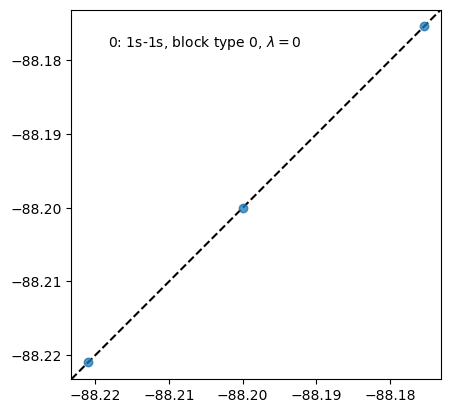

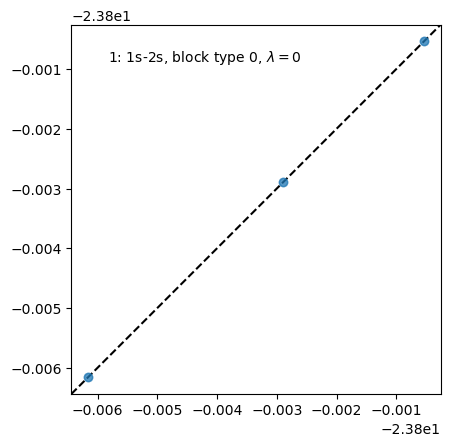

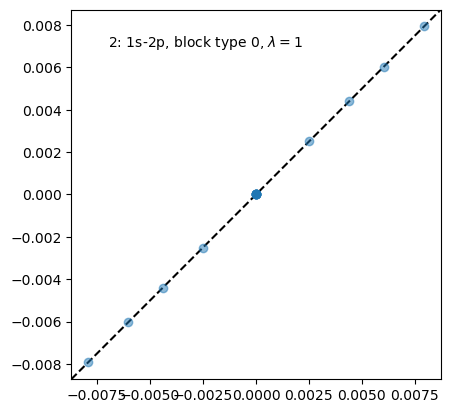

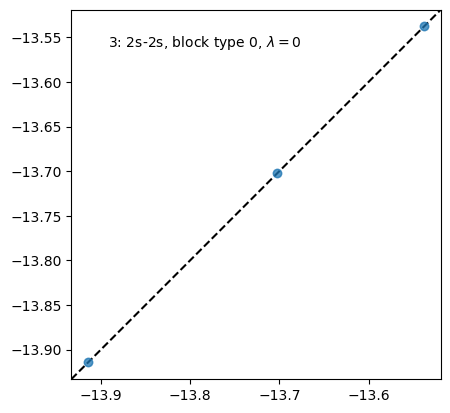

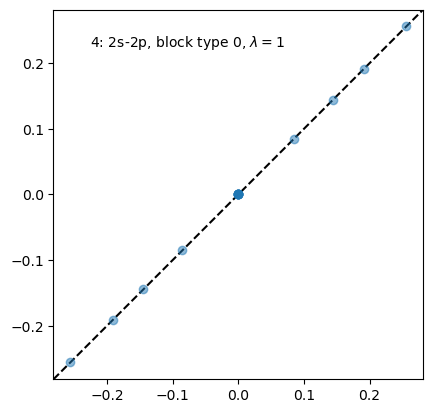

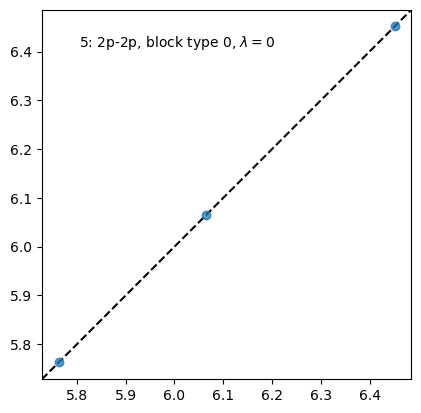

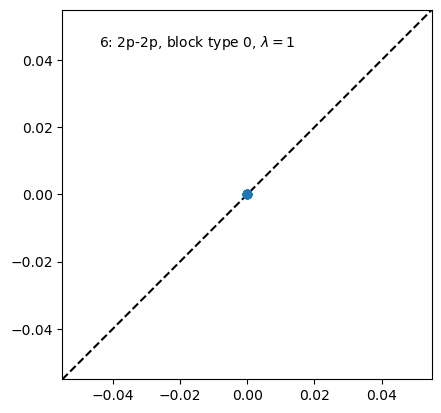

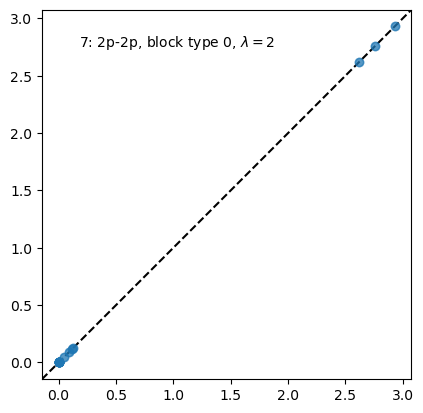

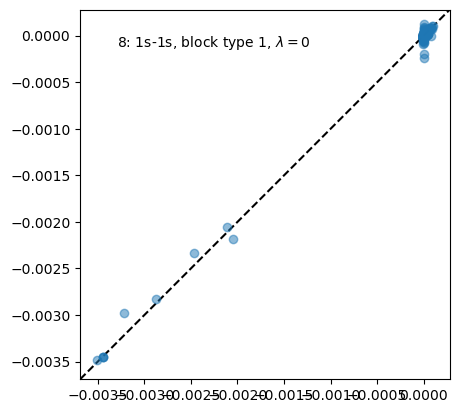

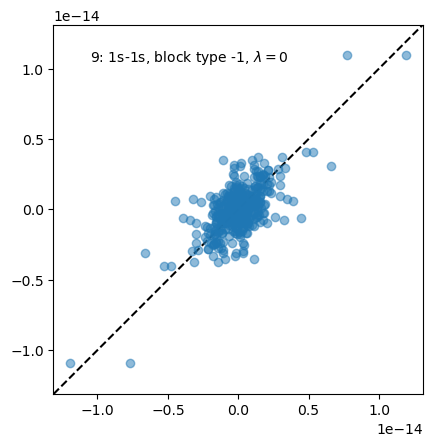

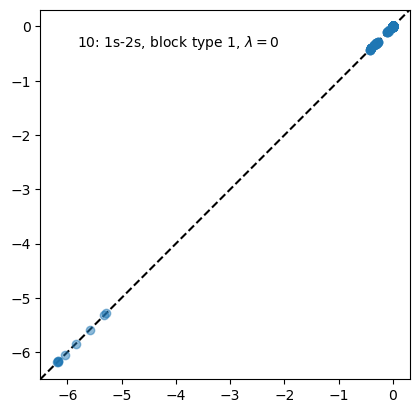

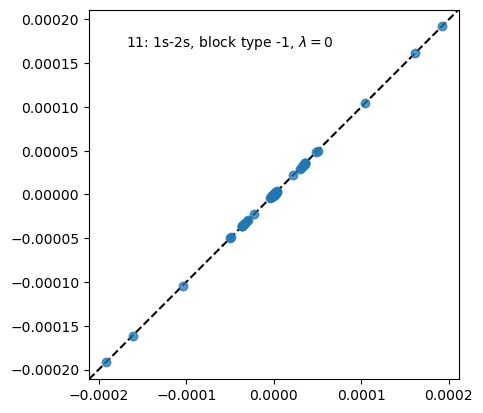

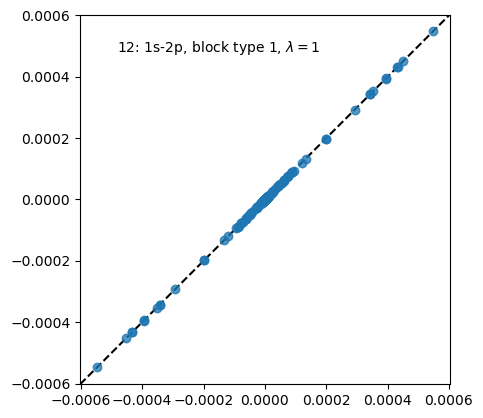

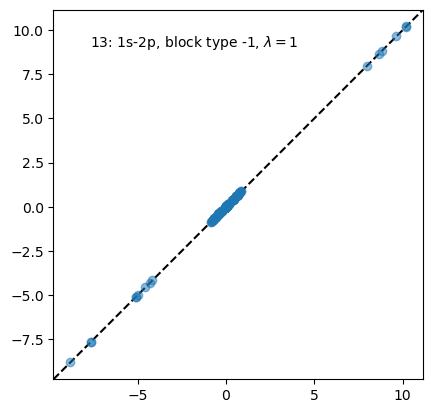

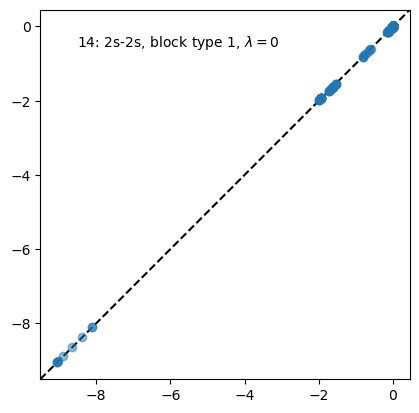

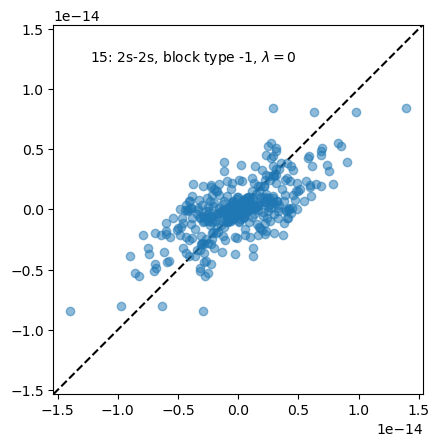

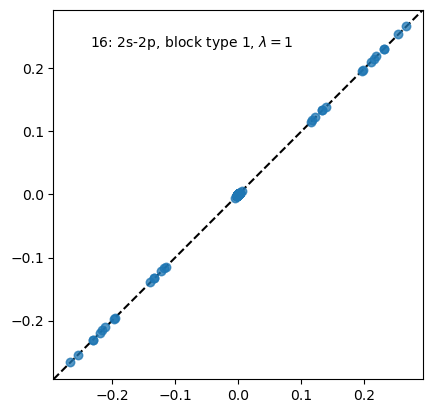

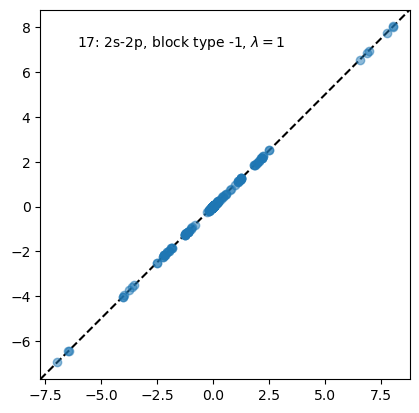

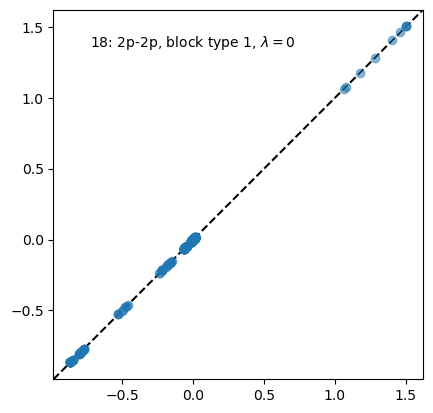

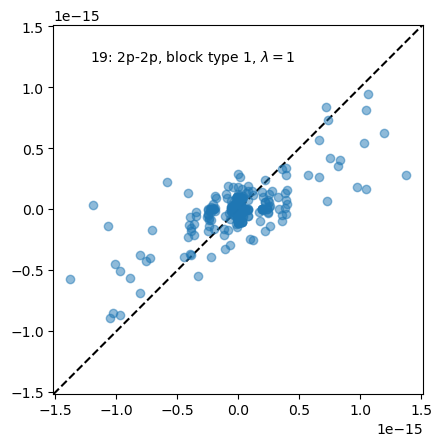

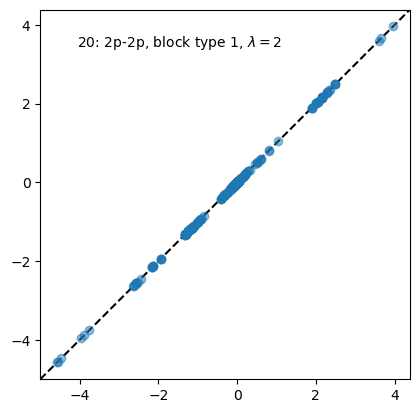

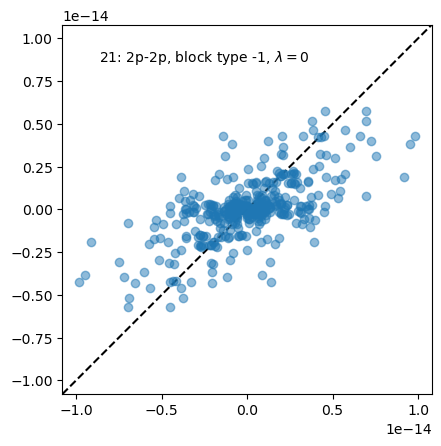

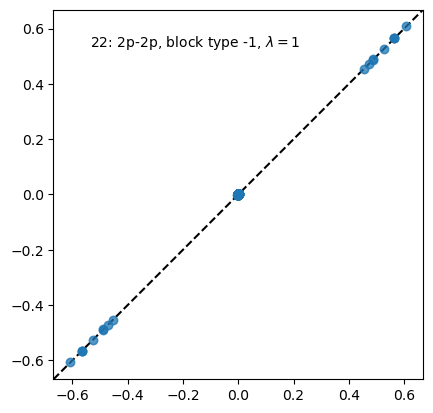

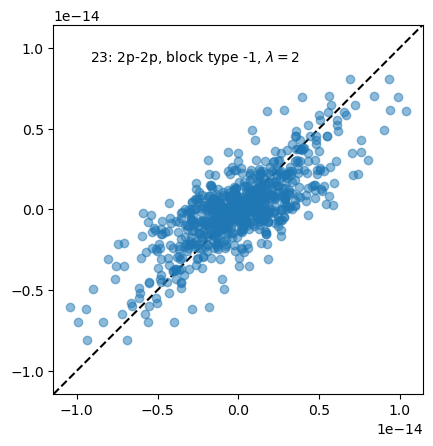

In [28]:
import matplotlib.pyplot as plt

orbital_label = {(1,0): '1s', (2,0): '2s', (2,1): '2p'}

for iblock, ((kt, bt), (kp, bp)) in enumerate(zip(target_coupled_blocks['hex'].items(), pred_ridge_bias.items())):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot(bt.values.flatten(), bp.values.flatten(), 'o', zorder = 1, alpha = 0.5)
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [xmin, xmax], ls = '--', c = 'k', zorder = 0)
    block_type, _, n1, l1, _, n2, l2, L = kt.values
    label = f'{iblock}: {orbital_label[n1,l1]}-{orbital_label[n2,l2]}, block type {block_type}, $\lambda={L}$'
    ax.text(0.1, 0.9, label, transform = ax.transAxes)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)
